# Track cells over time

1. Trackpy doesn't work as it takes into account one average cell/diameter size for all the cells to be tracked. And the cells in image differ widely. If the cells didn't vary widely and were mostly circular then tracking works better with trackpy.
2. This notebook is created with the help of trackpy docs - http://soft-matter.github.io/trackpy/v0.3.0/tutorial/walkthrough.html

In [1]:
import matplotlib.pyplot as plt

import cv2
import natsort
import numpy as np
import os
import glob
import pandas as pd
import sys
import trackpy as tp
import scipy.misc
import skimage.filters
import sklearn.metrics
import warnings; warnings.simplefilter('ignore')

import matplotlib as mpl
mpl.rc('figure',  figsize=(10, 6))
plt.ion()

1. Dataset - Rat mesenchymal stem cells on a flat polyacrylamide substrate from the http://celltrackingchallenge.net/2d-datasets/ is used
2. To understand how data is annotated and ground truths are saved - https://drive.google.com/file/d/1MGiwJo6h6PmUNzjL83JM77mYGFm8khH0/view?usp=sharing

Thanks and References to the dataset - 
1. Martin Maška, Vladimír Ulman, David Svoboda, Pavel Matula, Petr Matula, Cristina Ederra, Ainhoa Urbiola, Tomás España, Subramanian Venkatesan, Deepak M.W. Balak, Pavel Karas, Tereza Bolcková, Markéta Štreitová, Craig Carthel, Stefano Coraluppi, Nathalie Harder, Karl Rohr, Klas E. G. Magnusson, Joakim Jaldén, Helen M. Blau, Oleh Dzyubachyk, Pavel Křížek, Guy M. Hagen, David Pastor-Escuredo, Daniel Jimenez-Carretero, Maria J. Ledesma-Carbayo, Arrate Muñoz-Barrutia, Erik Meijering, Michal Kozubek, Carlos Ortiz-de-Solorzano; A benchmark for comparison of cell tracking algorithms, Bioinformatics, Volume 30, Issue 11, 1 June 2014, Pages 1609–1617, https://doi.org/10.1093/bioinformatics/btu080
2. Ulman, Vladimír & Maška, Martin & E G Magnusson, Klas & Ronneberger, Olaf & Haubold, Carsten & Harder, Nathalie & Matula, Pavel & Matula, Petr & Svoboda, David & Radojevic, Miroslav & Smal, Ihor & Rohr, Karl & Jaldén, Joakim & Blau, Helen & Dzyubachyk, Oleh & Lelieveldt, Boudewijn & Xiao, Pengdong & Li, Yuexiang & Cho, Siu-Yeung & Ortiz-de-Solorzano, Carlos. (2017). An Objective Comparison of Cell Tracking Algorithms. Nature Methods. 14. 10.1038/nmeth.4473. 


In [31]:
DATA_DIR = "/home/pranathi/Volumes/MicroscopyData/imaging_group/ucsf_microglia"
GRAYSCALE_DIR = os.path.join(DATA_DIR,"UCSF-2018-05-04-00-00-00-0001") + os.sep
GROUNDTRUTH_SEGMENTED_DIR = os.path.join(DATA_DIR, "UCSF-2018-05-04-00-00-00-0001_Annotated_Contours_Filled") + os.sep
GROUNDTRUTH_TRACKING_DIR = os.path.join(DATA_DIR, "groundtruth_tracking") + os.sep
LI_THRESHOLDED_DIR = os.path.join(DATA_DIR, "li_thresholded") + os.sep
YEN_THRESHOLDED_DIR = os.path.join(DATA_DIR, "yen_thresholded") + os.sep
OTSU_THRESHOLDED_DIR = os.path.join(DATA_DIR, "otsu_thresholded") + os.sep
CONFUSION_MATRIX_MASK_DIR = os.path.join(DATA_DIR, "confusion_matrix") + os.sep
FORMAT = "png"

GRAYSCALE_IMAGES = natsort.natsorted(glob.glob(GRAYSCALE_DIR + "*." + FORMAT))
GROUNDTRUTH_SEGMENTED_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_SEGMENTED_DIR + "*." + FORMAT))
GROUNDTRUTH_TRACKING_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_TRACKING_DIR + "*.tif"))

print("number of grayscale images are {}".format(len(GRAYSCALE_IMAGES)))
print("number of images manually segmented are {}".format(len(GROUNDTRUTH_SEGMENTED_IMAGES)))
print("number of images manually tracked are {}".format(len(GROUNDTRUTH_TRACKING_IMAGES)))
      
# Not all images are manually segmented, collect the subset of grayscale images that are manually segmented
data_files = []
for data in GRAYSCALE_IMAGES:
    for groundtruth in GROUNDTRUTH_SEGMENTED_IMAGES:
        if os.path.basename(groundtruth) == os.path.basename(data):
            data_files.append(data)

print("obtained {} number of grayscale images that are manually segmented".format(len(data_files)))

# To generate a video/gif from images in a folder/directory using ffmpeg run
# ffmpeg -framerate 5 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

number of grayscale images are 139
number of images manually segmented are 139
number of images manually tracked are 0
obtained 0 number of grayscale images that are manually segmented


Grayscale image info
/home/pranathi/Volumes/MicroscopyData/imaging_group/ucsf_microglia/UCSF-2018-05-04-00-00-00-0001/im_c000_z000_t000_p000.png
(512, 512)
int32
Ground truth for segmentation image info
/home/pranathi/Volumes/MicroscopyData/imaging_group/ucsf_microglia/UCSF-2018-05-04-00-00-00-0001_Annotated_Contours_Filled/SUM_20180504_Micr_GW23_GFP_TimeLapse_001.Pos001-0-annotated.png
(512, 512)
uint8
[  0 255]


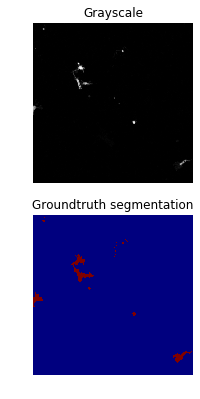

In [33]:
print("Grayscale image info")
grayscale_im_name = GRAYSCALE_IMAGES[0]
grayscale_im = scipy.misc.imread(grayscale_im_name)
print(grayscale_im_name)
print(grayscale_im.shape)
print(grayscale_im.dtype)

print("Ground truth for segmentation image info")
segment_gt_name =  GROUNDTRUTH_SEGMENTED_IMAGES[0]
segment_gt = scipy.misc.imread(segment_gt_name)
print(segment_gt_name)
print(segment_gt.shape)
print(segment_gt.dtype)
print(np.unique(segment_gt))

if len(GROUNDTRUTH_TRACKING_IMAGES) != 0:
    print("Ground truth for tracking image info")
    tracking_gt_name = GROUNDTRUTH_TRACKING_IMAGES[0]
    tracking_gt = scipy.misc.imread(tracking_gt_name)
    print(tracking_gt_name)
    print(tracking_gt.shape)
    print(tracking_gt.dtype)
    print(np.unique(tracking_gt))

plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.imshow(grayscale_im, cmap='gray')
plt.title("Grayscale")
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(segment_gt, cmap='jet')
plt.title("Groundtruth segmentation")
plt.axis("off")
if len(GROUNDTRUTH_TRACKING_IMAGES) != 0:
    plt.subplot(3, 1, 3)
    plt.imshow(tracking_gt, cmap='jet')
    plt.title("Groundtruth tracking")
    plt.tight_layout()
    plt.axis("off")

In [34]:
def images_to_npy(im_names):
    """
    Loads all images and converts them to a numpy stack

    Inputs:
    data_dir = list of images

    Outputs:
    returns image stack as (z stack, tile size_x, tile size_y)
    """
    image = scipy.misc.imread(im_names[0])
    shape = image.shape
    dtype = image.dtype
    im_stack = np.zeros((len(im_names), shape[0], shape[1]), dtype=dtype)
    
    for i in range(len(im_names)):
        im = scipy.misc.imread(im_names[i])
        im_stack[i, :, :] = im

    return im_stack

In [36]:
if len(GROUNDTRUTH_TRACKING_IMAGES) != 0:
    # Make a stack of all the frames that are already segmented/tracked
    tracking_groundtruth_stack = images_to_npy(GROUNDTRUTH_TRACKING_IMAGES)
    # Plot the first image
    plt.imshow(tracking_groundtruth_stack[0], cmap='jet')

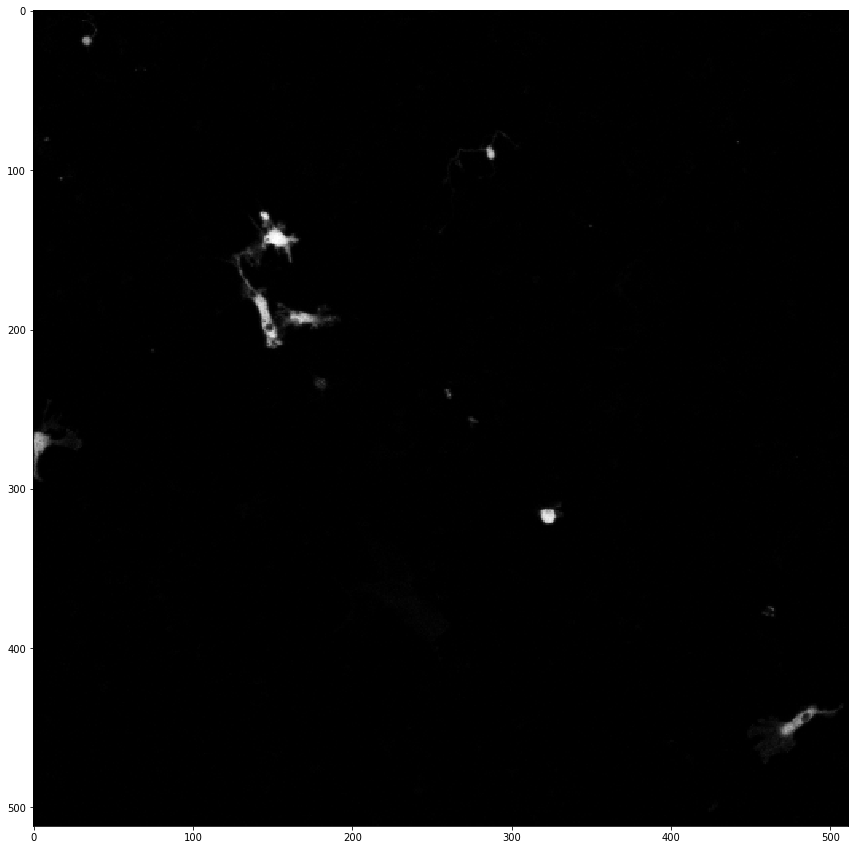

In [37]:
# Make a stack of all the raw frames in grayscale
grayscale_stack = images_to_npy(GRAYSCALE_IMAGES)
# Plot the first image
plt.imshow(grayscale_stack[0], cmap='gray')

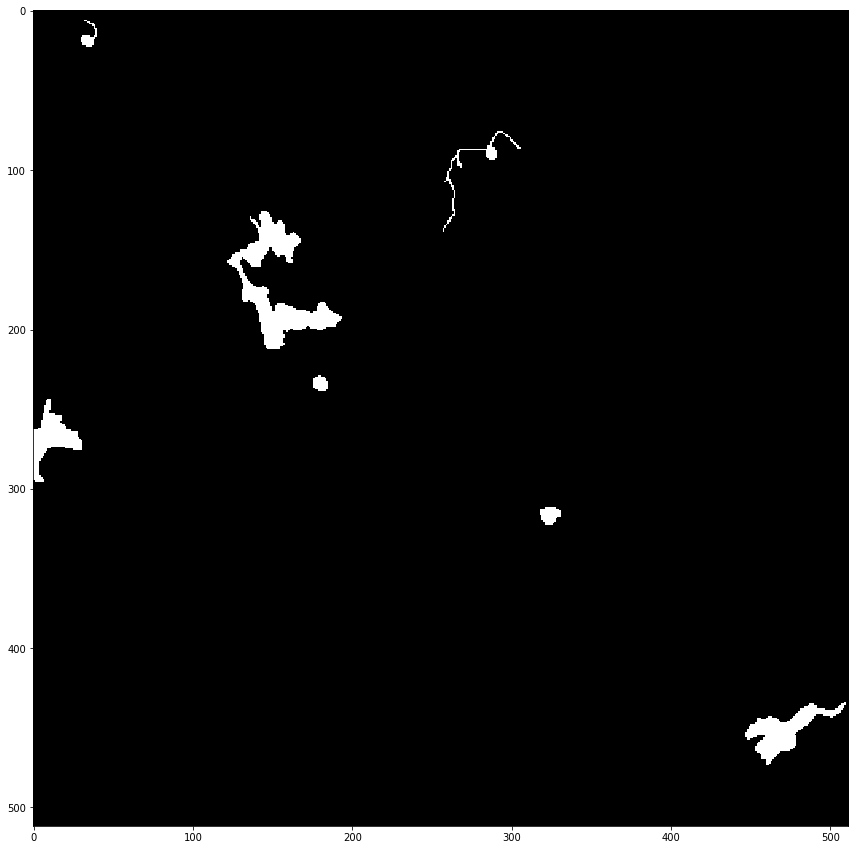

In [38]:
# Make a stack of all the raw frames in grayscale
segmented_groundtruth_stack = images_to_npy(GROUNDTRUTH_SEGMENTED_IMAGES)
# Plot the first image
plt.imshow(segmented_groundtruth_stack[0], cmap='gray')

1. From the picture above we can see that cells are not ellipses or circles i.e diameters would vary in different directions. we can find diameter of the cells by fitting ellipses and finding major and minor axis using opencv contours for one segmented image and repeat if for n segmented images to find average size in x, y that would work to locate and track the cells. 

2. As a start point, we can estimate it by looking at it, we can see each cell is atleast 10 pixel wide in both x and y, so we can start off with 11. 

# Usage of trackpy(tp)
1. Purpose of the Function tp.locate - Locates Gaussian-like bright blobs of some approximate size(diameter) in an image with a given separation between two blobs/features/cells.
2. Notes on parameter "diameter" - Diameter/Size may be a single number or a tuple giving the feature's extent in each dimension, useful when the dimensions do not have equal resolution (e.g. confocal microscopy). The tuple order is the same as the image shape, conventionally (z, y, x) or (y, x). The number(s) must be odd integers

Estimate feature size

Text(0.5, 1.0, 'Diameter(x) vs cell count(y)')

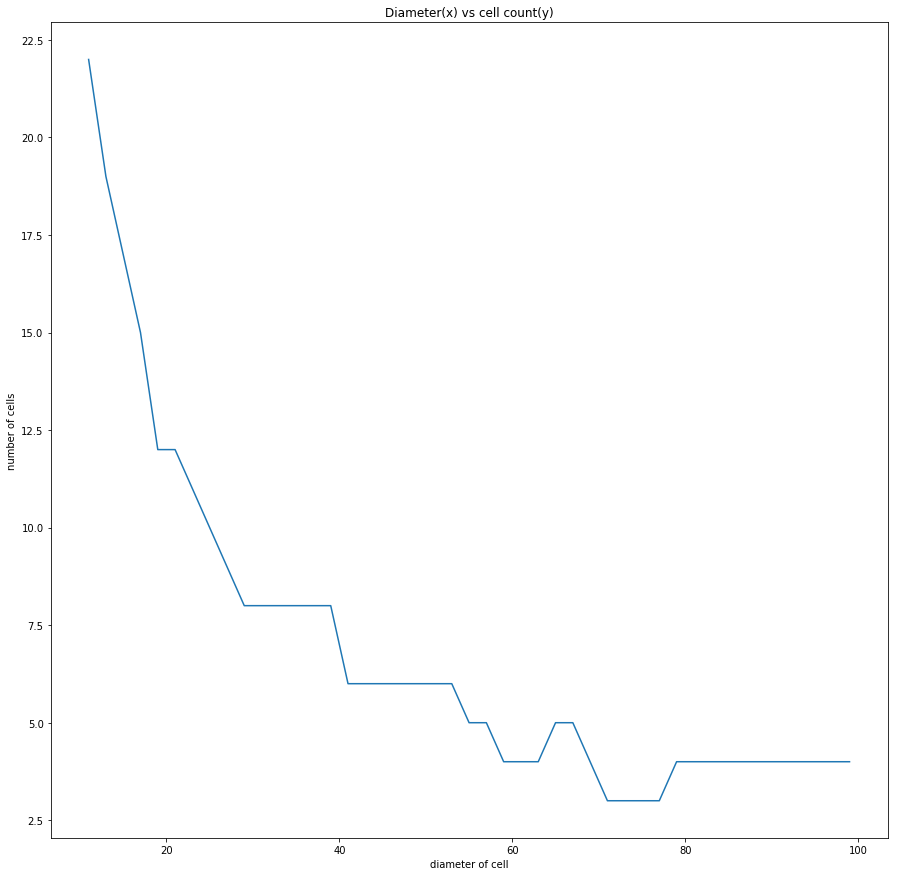

In [39]:
# Look at first frame to find a rough estimate of feature size

segmented_groundtruth_stack[segmented_groundtruth_stack != 0] = 255
segmented_groundtruth_stack = segmented_groundtruth_stack.astype(np.uint8)
detected_cell_count = []
cell_sizes = []

for diameter in range(10, 100):
    if diameter % 2 != 0:
        cell_df = tp.locate(segmented_groundtruth_stack[0, :, :], diameter=diameter, separation=diameter+1)
        number_of_detected_cells = cell_df.shape[0]
        detected_cell_count.append(number_of_detected_cells)
        cell_sizes.append(diameter)

plt.plot(cell_sizes, detected_cell_count)
plt.xlabel("diameter of cell")
plt.ylabel("number of cells")
plt.title("Diameter(x) vs cell count(y)")

There are 9 cells if we count in the ground truth image, and it seems like diameter of cells greater than 20 are close to having cells less less than or equal to 10. so, lets locate and plot features obtained onto the original image for the diameter range within 20 to 80

# Locate features

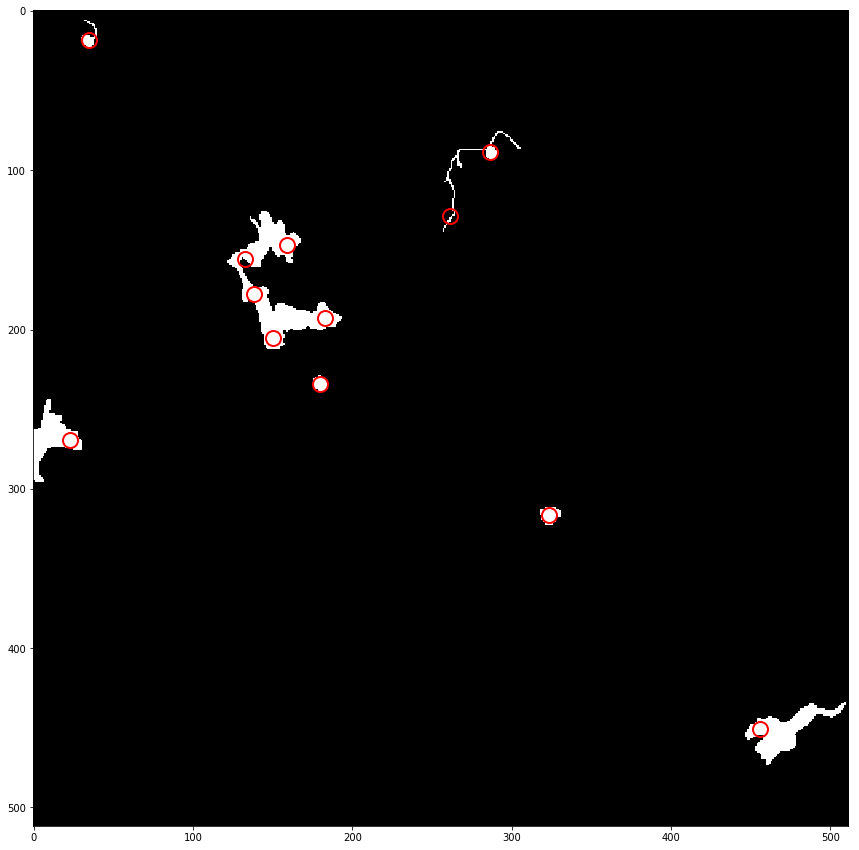

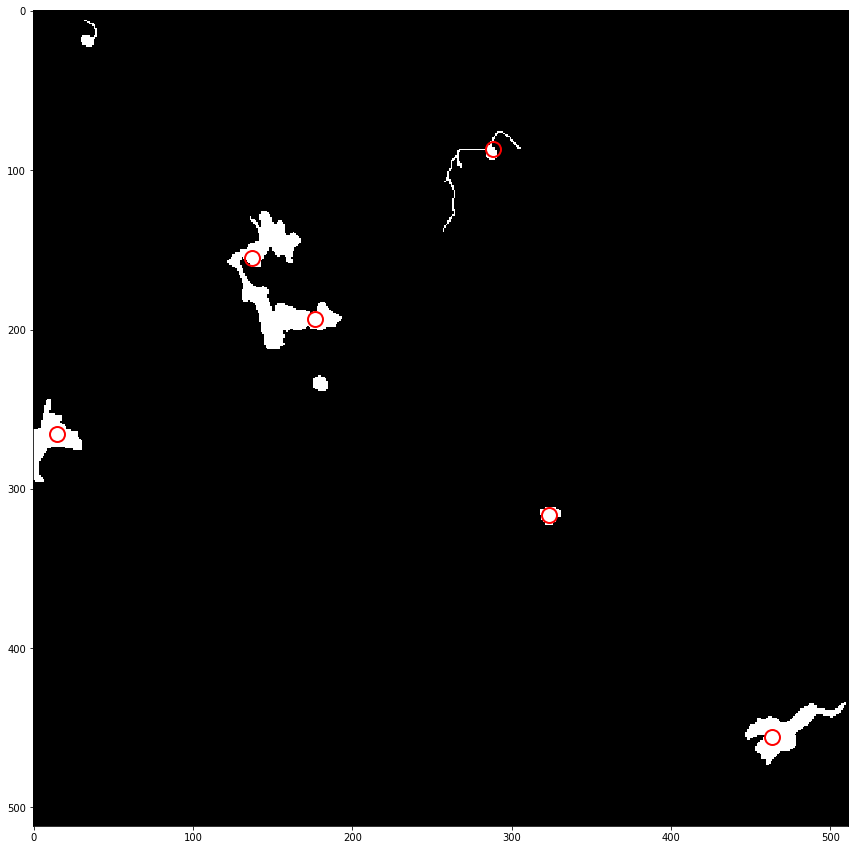

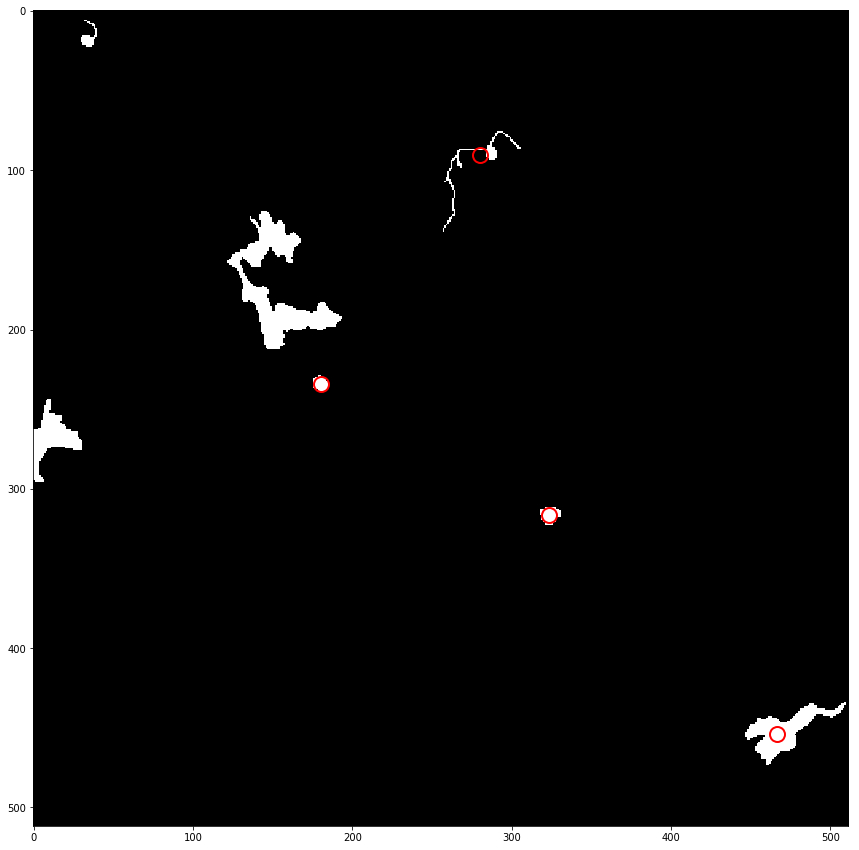

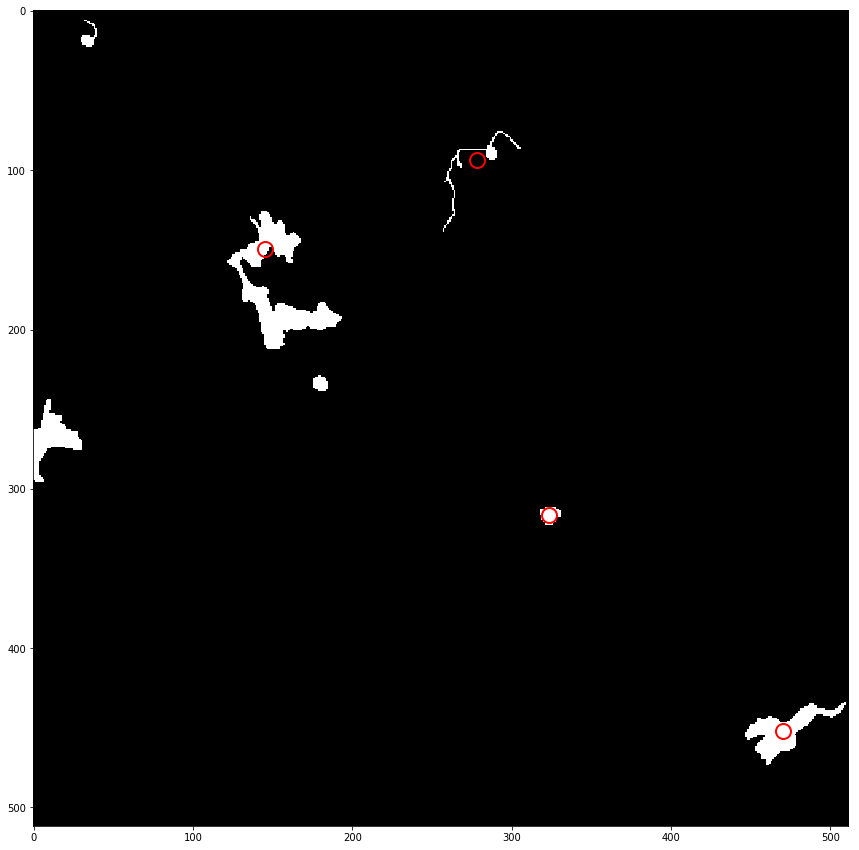

In [40]:
plt.figure()
plt.rcParams['figure.figsize'] = [15, 15]
for diameter in range(21, 100, 20):
    if diameter % 2 == 0: diameter = diameter + 1
    cell_df = tp.locate(
        segmented_groundtruth_stack[0, :, :], diameter=diameter, separation=diameter+1)
    tp.annotate(cell_df, segmented_groundtruth_stack[0, :, :])

In [41]:
diameter = 21
minmass = 5000
maxsize = 5000
percentile = 75
cell_df = tp.locate(
        segmented_groundtruth_stack[0, :, :], diameter=diameter, separation=diameter+1)
print(cell_df.head())

             y           x          mass      size       ecc      signal  \
0    88.501510  286.638349  11229.355493  3.810087  0.146598  217.404079   
1   155.543699  132.369545  21701.275174  6.690846  0.364409  180.010577   
12  233.841541  179.957219  13456.442879  3.382569  0.080605  212.186381   
35  316.436065  323.760108  17722.780527  4.105132  0.071401  192.185206   

    raw_mass   ep  
0    16575.0  0.0  
1    48705.0  0.0  
12   18615.0  0.0  
35   27540.0  0.0  


# Refine parameters to elminate spurious features

Text(0.5, 1.0, 'mass vs count')

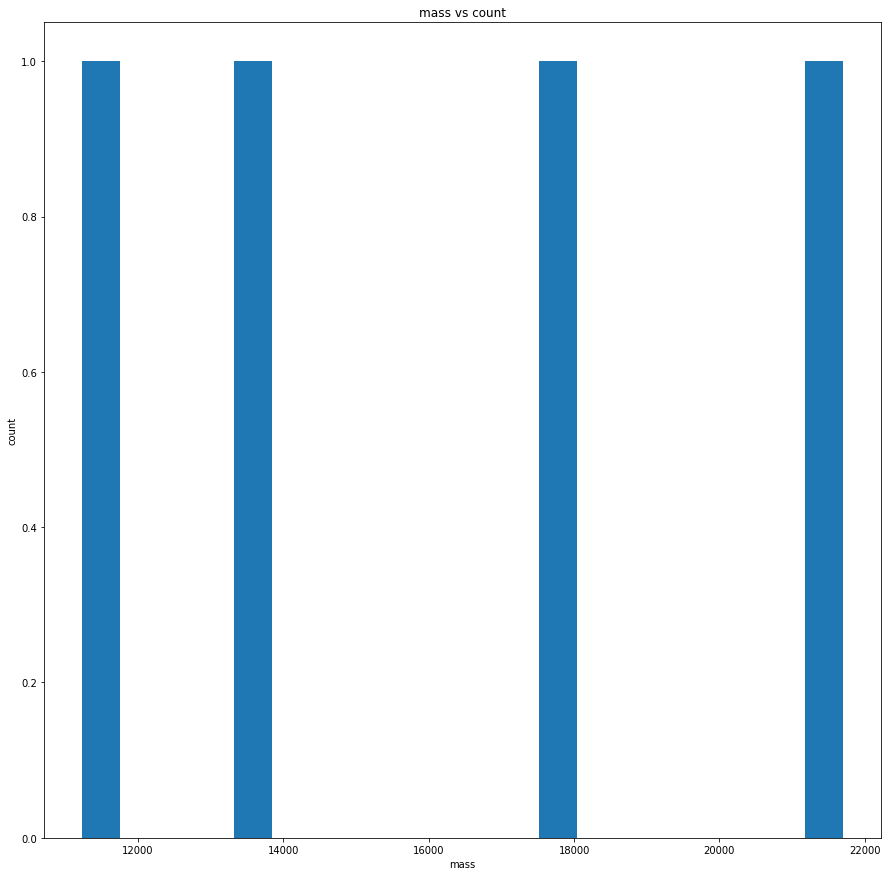

In [42]:
fig, ax = plt.subplots()
ax.hist(cell_df['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count')
plt.title("mass vs count")

In [44]:
frames_df = tp.batch(segmented_groundtruth_stack, diameter=diameter, minmass=minmass, maxsize=maxsize, percentile=percentile)

Frame 138: 4 features


In [52]:
track_df = tp.link_df(frames_df, 20, memory=3)
print('Before:', track_df['particle'].nunique())
track_df = tp.filter_stubs(track_df, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('After:', track_df['particle'].nunique())
print(track_df.head())

Frame 138: 4 trajectories present.
Before: 29
After: 14
                y           x           mass       size       ecc      signal  \
frame                                                                           
0       93.687098  278.125665   39295.527096  18.456507  0.642169  248.787421   
0      316.444229  323.758636   26569.703603   4.451359  0.063456  250.769791   
0      452.058710  470.101698  173182.806932  15.838482  0.312206  225.990167   
1       96.440442  274.956234   83126.637709  16.430987  0.665897  240.113879   
1      316.251590  324.113976   36677.395043   5.334893  0.075744  249.954612   

       raw_mass   ep  frame  particle  
frame                                  
0       43350.0  0.0      0         0  
0       27540.0  0.0      0         2  
0      206550.0  0.0      0         3  
1       93330.0  0.0      1         0  
1       38250.0  0.0      1         2  


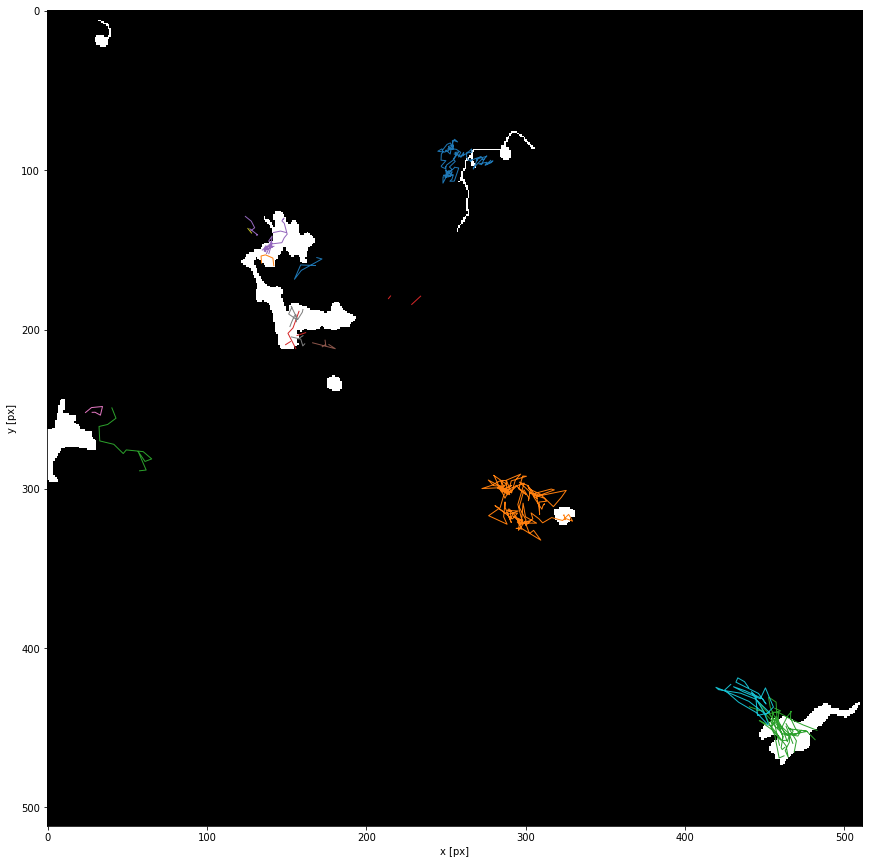

(300, 600)

In [47]:
plt.figure()
tp.plot_traj(track_df, superimpose=segmented_groundtruth_stack[0, :, :]).set_xlim(300,600)

In [54]:
# track_df.rename(columns={'frame':'index'}, inplace=True)
# drift_df = tp.compute_drift(track_df)
# plt.figure()
# drift_df.plot()

KeyError: "['frame'] not in index"

In [ ]:
# track_df = tp.subtract_drift(track_df, drift_df)
# plt.figure()
# tp.plot_traj(track_df, superimpose=segmented_groundtruth_stack[0]).set_xlim(300,600)